# Setup

In [5]:
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from glob import glob
from tqdm import tqdm
from copy import deepcopy
import pickle
from cifar10_utils import get_cifar10, get_dataloader

from models_v2 import (BasicCNN, AutoencoderCNN, ECACNN, AutoencoderECACNN,
                       ECASpatialCNN, DeeperCNN, LinearAutoencoderECACNN, CBAMCNN)


In [6]:
# Seed for reproduceability
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)

# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
use_cuda = torch.cuda.is_available()
print(device)

cpu


In [3]:
# Grad-CAM: for more info https://jacobgil.github.io/pytorch-gradcam-book/introduction.html
%pip install grad-cam --quiet
from pytorch_grad_cam import GradCAM, GradCAMElementWise, HiResCAM, LayerCAM, FullGrad, AblationCAM, ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 21.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
cifar10 = get_cifar10()
cifar10_loader = get_dataloader(cifar10, 128)

## Loading the Models

In [ ]:
cnn_model = BasicCNN().to(device)
autoencoder_model = AutoencoderCNN().to(device)
eca_model = ECACNN().to(device)
autoencoder_eca_model = AutoencoderECACNN().to(device)
eca_spatial_model = ECASpatialCNN().to(device)
deeper_cnn_model = DeeperCNN().to(device)
linear_autoencoder_model = LinearAutoencoderECACNN().to(device)
cbam_model = CBAMCNN().to(device)


In [ ]:
best_models = {'cnn': cnn_model,
          'eca': eca_model,
          'cbam': cbam_model,
          'autoencoder': autoencoder_model,
          'autoencoder_eca': autoencoder_eca_model,
          'linear_autoencoder_eca': linear_autoencoder_model,
          'eca_spatial': eca_spatial_model,
          'deeper_cnn': deeper_cnn_model,
}

for name, model in best_models.items():
    model.load_state_dict(torch.load('best_models.pt', map_location=torch.device('cpu'))[name])


In [ ]:
with open('longer_trained_models.pt', 'rb') as f:
    longer_trained_models = torch.load(f)

## Loading Results Data

In [9]:
with open('all_results_data.pkl', 'rb') as f:
    all_results_data = pickle.load(f)



---



# Results analysis

In [10]:
average_test_accuracies = {}
best_test_accuracies = {}
average_test_losses = {}
average_best_valid_accuracies = {}
std_test_accuracies = {}


for name, model in all_results_data.items():
    test_accuracies = [model[run]['test_accuracy'] for run in range(len(model))]
    test_losses = [model[run]['test_loss'] for run in range(len(model))]
    best_valid_accuracies = [np.max(model[run]['logging_dict']['accuracy']['validation']) for run in range(len(model))]

    average_test_accuracies[name] = np.average(test_accuracies)
    average_test_losses[name] = np.average(test_losses)
    average_best_valid_accuracies[name] = np.average(best_valid_accuracies)
    best_test_accuracies[name] = np.max(test_accuracies)
    std_test_accuracies[name] = np.std(test_accuracies)


average_test_accuracies, std_test_accuracies

({'cnn': 0.6667511372626582,
  'eca': 0.6674557456487342,
  'cbam': 0.6418364319620253,
  'autoencoder': 0.6746439873417722,
  'autoencoder_eca': 0.6652862935126582,
  'linear_autoencoder_eca': 0.6073291633702531,
  'eca_spatial': 0.6685682852056962,
  'deeper_cnn': 0.6645075158227849},
 {'cnn': 0.018893083368881534,
  'eca': 0.023452770114145892,
  'cbam': 0.025581481626441922,
  'autoencoder': 0.01988106309039409,
  'autoencoder_eca': 0.018313657079510656,
  'linear_autoencoder_eca': 0.032430559890446214,
  'eca_spatial': 0.013558224866598865,
  'deeper_cnn': 0.025871021497234928})

In [180]:
def make_plots(logging_dict, model_name, avg_train=True):
    epoch_ends = np.cumsum(logging_dict['batches_per_epoch'])

    def get_avg_per_epoch(batch_data):
        result = [None,]
        for i in range(len(epoch_ends) - 1):
            result.append(np.average(batch_data[epoch_ends[i]:epoch_ends[i + 1]]))
        return result

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    metrics = ('loss', 'accuracy')
    for metric, ax in zip(metrics, axes.ravel()):
        if avg_train:
            ax.plot(get_avg_per_epoch(logging_dict[metric]['train']), '.-', label='training set')
            ax.plot(logging_dict[metric]['validation'], '.-', label='validation set')
            ax.set(title=metric, xlabel='epoch', xticks=np.arange(len(epoch_ends)))
        else:
            ax.plot(logging_dict[metric]['train'],'.-', label='training set')
            ax.plot(epoch_ends, logging_dict[metric]['validation'],'.-', label='validation set')
            ax.set(title=metric, xlabel='batch')

    handles, labels = ax.get_legend_handles_labels()
    plt.figlegend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)
    plt.suptitle(model_name)
    plt.tight_layout()
    plt.show()

---

# Parameter Count

In [32]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [33]:
for name, model in best_models.items():
    print(name, f'{count_params(model):,}')

cnn 2,625,866
eca 2,625,878
cbam 2,628,830
autoencoder 2,918,570
autoencoder_eca 2,918,582
linear_autoencoder_eca 2,722,272
eca_spatial 2,626,072
deeper_cnn 3,512,138


---

# Grad-CAM Visualizations

In [38]:
classes_names = {i: c for i, c in enumerate (('airplane', 'automobile', 'bird', 'cat', 'deer',
                                              'dog', 'frog', 'horse', 'ship', 'truck',))}
def compare_activations(models_dict: dict, target_layers, image_number=None, dataset=cifar10['train'], use_cuda=use_cuda):
    '''
    Compare gradcam visualizations of differenct models.
    If image_number is None, a random image will be selected.
    '''
    fig, axs = plt.subplots(1, len(models_dict), figsize=(10, 3))
    if image_number == None:
        image_number = np.random.randint(len(dataset))
    img, label = dataset[image_number]

    def normalize(img):
        return ((img - img.min()) / (img.max() - img.min()))

    def inverse_normalize(img):
        invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
        return invTrans(img)


    # Show original image
    axs = axs.ravel()
    axs[0].imshow(torch.permute(inverse_normalize(img), (1, 2, 0)))
    axs[0].axis('off')
    axs[0].set(title='Original Image')

    # Show activations for each model
    for i, (model, ax) in enumerate(zip(list(models_dict.items()), axs[1:])):
        model_name = model[0]
        model_instance = model[1]
        target_layer = [model_instance.get_submodule(target_layers)]

        model_instance.eval()
        input_tensor = img.unsqueeze(0).to(device)
        cam = FullGrad(model=model_instance, target_layers=target_layer, use_cuda=use_cuda)
        targets = None
        grayscale_cam = cam(input_tensor, targets, eigen_smooth=True)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(normalize(torch.permute(img, (1, 2, 0))).numpy(), grayscale_cam, use_rgb=True)
        ax.imshow(visualization)
        ax.axis('off')
        ax.set(title=f'{model_name}')

        # Display classifiction results

        with torch.no_grad():
            probabilities = model_instance(input_tensor)
        results = [(classes_names[index], prob) for index, prob in enumerate(probabilities.squeeze(0))]
        results_sorted = sorted(results, key=lambda item: item[1], reverse=True)
        results_text = '\n'.join([f'{res[0]} ({res[1].item():.2f})' for res in results_sorted[:3]])
        ax.annotate(results_text, (0.5, -0.1), (0, 0), xycoords='axes fraction', textcoords='offset points', va='top', ha='center');

    plt.suptitle(f'{classes_names[label]} ({label}) (image {image_number})')
    plt.tight_layout()
    plt.show()

Exception ignored in: <function BaseCAM.__del__ at 0x7ee29ff212d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'FullGrad' object has no attribute 'activations_and_grads'


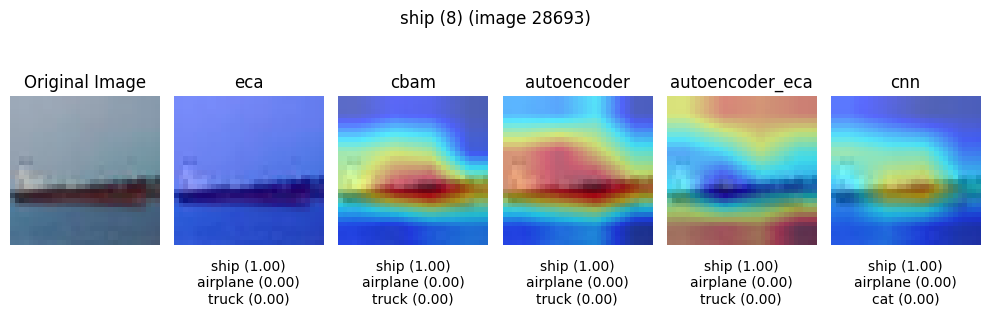

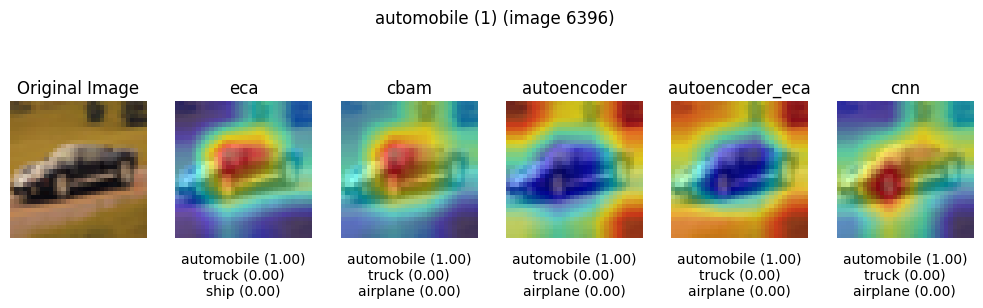

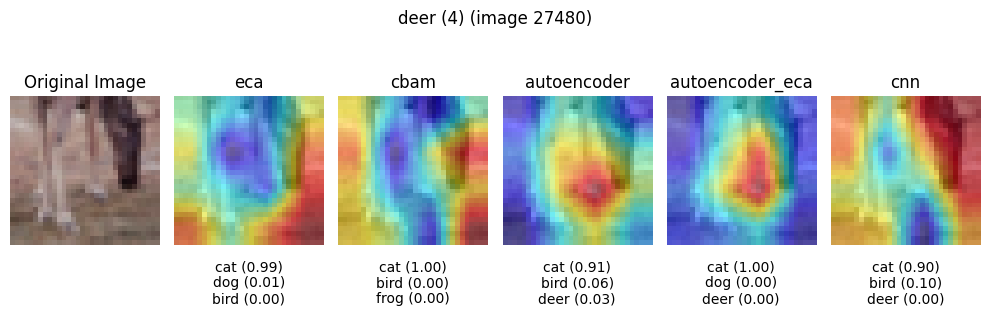

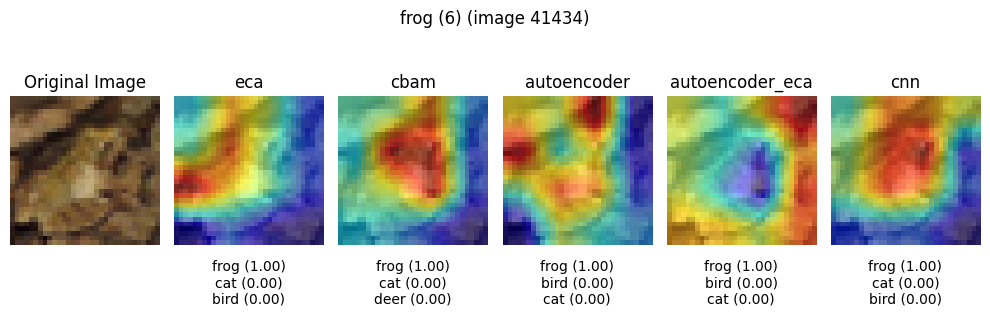

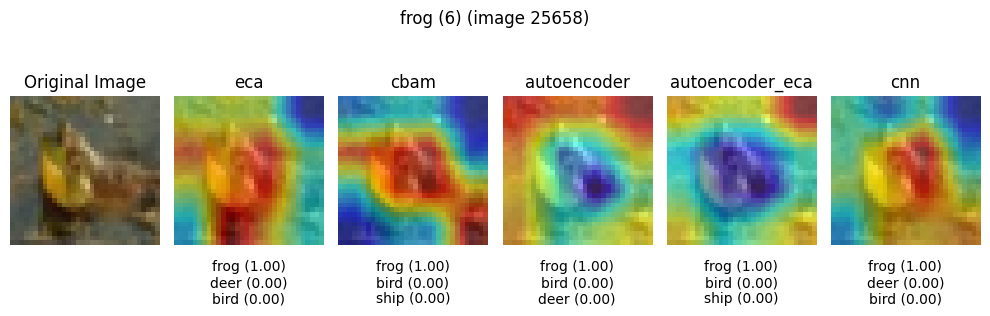

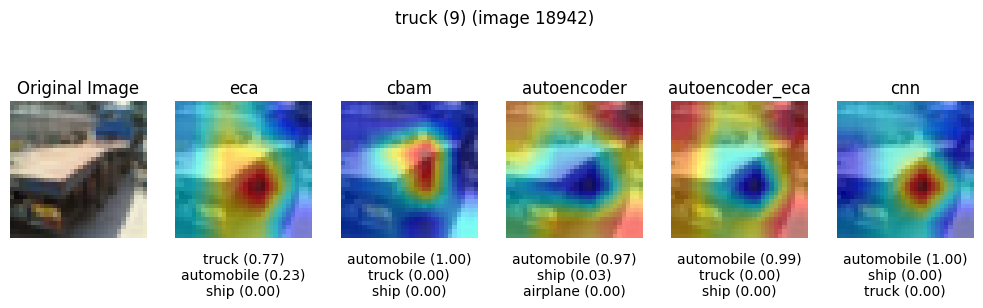

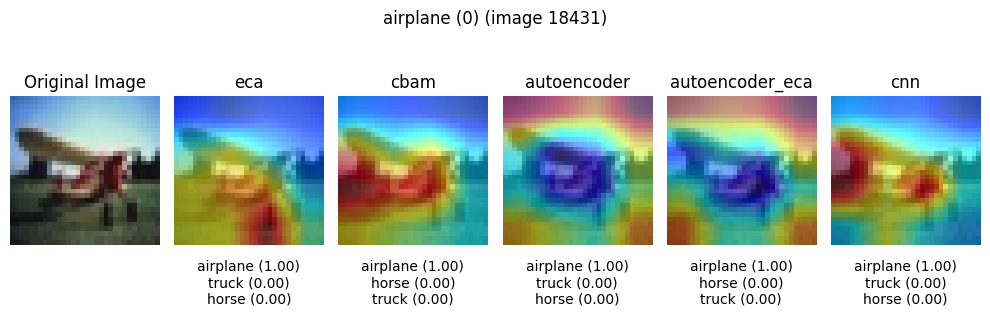

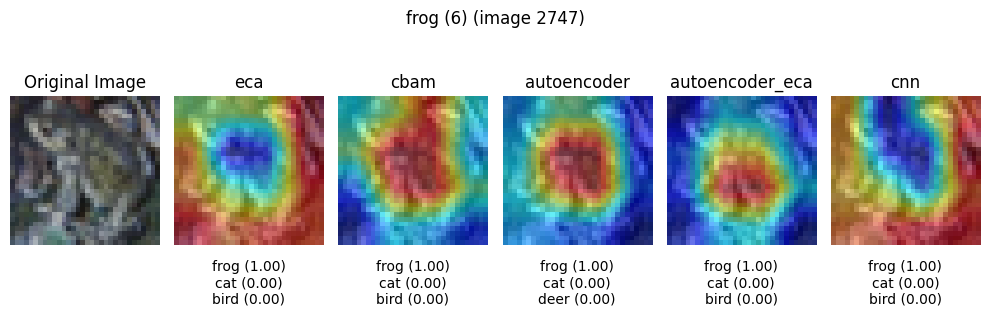

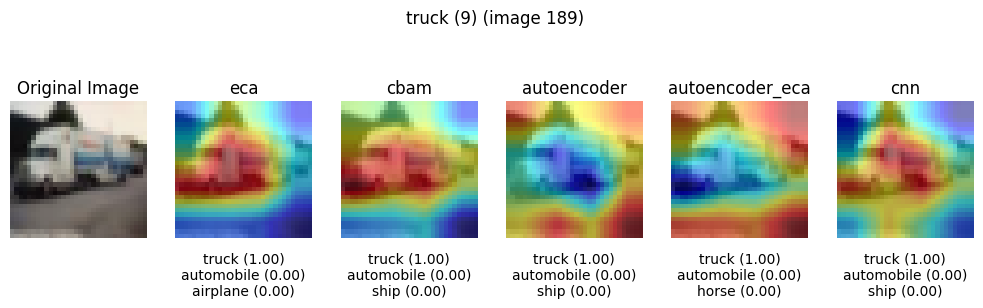

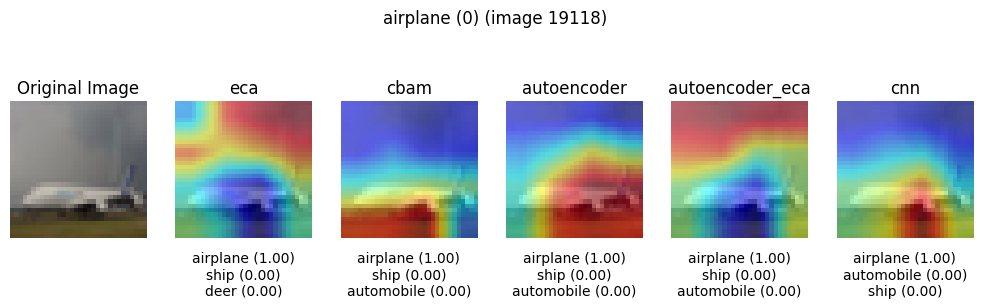

In [41]:
for _ in range(10):
    compare_activations(models_dict=longer_trained_models, target_layers='layer2', dataset=cifar10['train'])